<a href="https://colab.research.google.com/github/UrukHan/NeuroNetStockQuotes/blob/master/PolinomialRegressionKerasTuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Импорт библиотек**

In [1]:
# Установка пакетов
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 1.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=c240c4e14a88a85565d0644065e8114c07d13a9a6d7f9b6e365d26d2c751d51e
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=66439f8e5adb631c5d29474d8cbfb0749f0ed3bf14d748139d97045d8739b644
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
# Импорт библиотек
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import utils
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization #
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch 
from kerastuner import HyperModel 
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import kerastuner as kt 
import os


%matplotlib inline 

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

# Load the TensorBoard notebook extension.
%load_ext tensorboard

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0


In [3]:
# Clear logs from previous calls
!rm -rf ./logs/ 

# Check
!ls

sample_data


In [4]:
# Установка начальных значений для операций на основе хэша в python
os.environ['PYTHONHASHSEED'] = '0'
seed=1234

# Установка numpy seed
np.random.seed(seed)

# Установка случайного начального числа в тензорном потоке на уровне графа
tf.compat.v1.set_random_seed(seed)

## **Загрузка данных**

In [5]:
# Загрузка данных
allData = pd.read_json('/content/stockQuotes.json')
allData.iloc[:3]

,AA,AES,AIG,APA,AUY,AXP,BA,BAC,BBVA,BK,BMY,BWA,C,CAT,CDE,CLF,CNP,COG,CPE,CVX,DAL,DNR,DVN,EMR,EQNR,EQT,F,FCX,FTI,GFI,GLW,GM,GOLD,GPS,GS,HAL,HD,HIG,HL,HOG,...,INFY,IVZ,JPM,KEY,KGC,KIM,KOS,KSS,LUV,LYG,MDT,MGM,MPC,MRO,MS,NE,NLY,NOV,OKE,OXY,PCG,QEP,RF,RIG,RRC,RWT,SAVE,SCHW,SLB,SPG,STT,SWN,TFC,TJX,USB,VER,WFC,WMB,X,XOM
0,7.1230,11.3047,23.9400,5.6824,2.910,87.6466,131.555,21.1288,2.9712,30.1326,51.9017,23.7164,42.0176,96.0501,2.680,4.0417,12.7553,17.510,0.6100,70.6600,36.2451,0.3000,7.6032,47.7785,9.9041,8.7937,5.0721,6.4027,6.2026,4.6800,19.3631,21.5790,16.21,8.3836,156.9206,6.1326,168.2803,34.2243,1.700,21.0388,...,7.4231,8.9637,92.3286,10.2843,4.0800,10.8345,0.8004,19.3081,38.21,1.5907,79.2731,10.9246,20.8287,4.1517,32.3835,0.2801,6.9629,9.2639,25.02,12.39,9.5538,0.6403,8.4635,1.3206,2.8112,9.3939,12.1051,31.3681,14.5361,66.9900,49.1805,1.9208,28.2918,41.4655,33.3839,5.6223,27.5515,13.5757,5.4423,35.3148
1,6.9322,9.9900,21.0667,4.8215,3.345,85.1671,110.215,20.8516,2.9550,29.2243,52.6367,22.0970,40.6229,95.5804,3.246,4.1944,12.4540,18.766,0.5413,67.1113,33.9508,0.2885,7.3173,46.7549,9.8500,9.2500,4.7815,6.1100,5.9519,5.2367,18.9550,19.9563,17.46,7.4874,153.7300,5.7300,161.3413,32.5003,2.045,20.4265,...,7.4300,8.4100,89.9638,9.6281,4.5815,10.3533,0.6703,16.5503,36.18,1.5955,78.9251,10.1732,18.9760,4.0613,31.1800,0.2972,6.6062,8.5800,22.88,11.65,9.2300,0.5197,8.3176,1.2700,3.0200,8.3577,11.2436,29.9695,13.5393,60.9694,46.9049,2.3150,27.3187,40.2328,31.7351,5.3517,27.5267,13.1542,6.0969,36.1615
2,7.0700,10.6100,21.3200,5.1650,3.530,85.4300,112.830,21.2050,3.0500,29.6000,53.0000,21.7800,42.3200,96.8900,3.460,4.1350,12.7800,18.800,0.5700,68.4100,34.2200,0.3100,7.7800,47.2100,10.2600,9.0850,4.9500,6.0500,6.0900,5.3100,20.5388,20.3400,18.12,7.6150,161.4350,6.0800,164.7600,31.2600,2.100,21.0100,...,7.5750,8.8900,92.1200,9.9500,4.7600,10.5700,0.7600,17.3300,37.82,1.5900,78.1600,10.1200,20.4900,4.0500,33.1600,0.3000,6.6650,9.5500,22.13,12.37,9.5900,0.5400,8.5800,1.3400,3.0101,7.8300,11.2200,31.0300,13.7100,60.7900,48.7000,2.2300,29.1100,41.9000,33.3400,5.3900,29.3400,12.5100,6.0000,37.0300


## **# Подготовка данных к использованию сетью**

In [329]:
# Создание копии таблицы данных
dataSetFull = allData.copy()
# Заменяем значения таблицы на значения равным разнице между строками
dataSetFull = dataSetFull.diff().shift(-1)
dataSetFull = dataSetFull.dropna()
dataSetFull.head(3)

,AA,AES,AIG,APA,AUY,AXP,BA,BAC,BBVA,BK,BMY,BWA,C,CAT,CDE,CLF,CNP,COG,CPE,CVX,DAL,DNR,DVN,EMR,EQNR,EQT,F,FCX,FTI,GFI,GLW,GM,GOLD,GPS,GS,HAL,HD,HIG,HL,HOG,...,INFY,IVZ,JPM,KEY,KGC,KIM,KOS,KSS,LUV,LYG,MDT,MGM,MPC,MRO,MS,NE,NLY,NOV,OKE,OXY,PCG,QEP,RF,RIG,RRC,RWT,SAVE,SCHW,SLB,SPG,STT,SWN,TFC,TJX,USB,VER,WFC,WMB,X,XOM
0,-0.1908,-1.3147,-2.8733,-0.8609,0.4350,-2.4795,-21.3400,-0.2772,-0.0162,-0.9083,0.7350,-1.6194,-1.3947,-0.4697,0.5660,0.1527,-0.3013,1.2560,-0.0687,-3.5487,-2.2943,-0.0115,-0.2859,-1.0236,-0.0541,0.4563,-0.2906,-0.2927,-0.2507,0.5567,-0.4081,-1.6227,1.2500,-0.8962,-3.1906,-0.4026,-6.9390,-1.7240,0.3450,-0.6123,...,0.0069,-0.5537,-2.3648,-0.6562,0.5015,-0.4812,-0.1301,-2.7578,-2.0300,0.0048,-0.3480,-0.7514,-1.8527,-0.0904,-1.2035,0.0171,-0.3567,-0.6839,-2.14,-0.7400,-0.3238,-0.1206,-0.1459,-0.0506,0.2088,-1.0362,-0.8615,-1.3986,-0.9968,-6.0206,-2.2756,0.3942,-0.9731,-1.2327,-1.6488,-0.2706,-0.0248,-0.4215,0.6546,0.8467
1,0.1378,0.6200,0.2533,0.3435,0.1850,0.2629,2.6150,0.3534,0.0950,0.3757,0.3633,-0.3170,1.6971,1.3096,0.2140,-0.0594,0.3260,0.0340,0.0287,1.2987,0.2692,0.0215,0.4627,0.4551,0.4100,-0.1650,0.1685,-0.0600,0.1381,0.0733,1.5838,0.3837,0.6600,0.1276,7.7050,0.3500,3.4187,-1.2403,0.0550,0.5835,...,0.1450,0.4800,2.1562,0.3219,0.1785,0.2167,0.0897,0.7797,1.6400,-0.0055,-0.7651,-0.0532,1.5140,-0.0113,1.9800,0.0028,0.0588,0.9700,-0.75,0.7200,0.3600,0.0203,0.2624,0.0700,-0.0099,-0.5277,-0.0236,1.0605,0.1707,-0.1794,1.7951,-0.0850,1.7913,1.6672,1.6049,0.0383,1.8133,-0.6442,-0.0969,0.8685
2,-0.0181,0.3300,0.5858,-0.1050,-0.1691,1.3800,4.3408,0.8008,0.0300,-0.4623,-0.2811,0.1858,-0.2864,1.9300,-0.1991,0.0050,-0.0850,0.6051,-0.0190,1.0400,1.0800,-0.0078,-0.1900,-0.8650,-0.0200,0.2124,0.1563,0.1850,-0.0600,-0.1236,-0.4488,0.4700,-0.5204,0.6322,-1.5450,0.1094,5.4347,1.1285,-0.1895,1.0058,...,0.1700,0.5500,2.5100,-0.0050,-0.1488,0.2528,-0.0297,0.6100,0.7301,0.0250,1.1403,0.4100,0.2254,-0.0400,0.5700,0.0038,-0.1100,-0.1900,0.97,-0.0268,-0.1000,-0.0383,0.5200,-0.0046,0.0407,0.0421,0.1466,0.5583,0.3887,0.3931,0.3100,-0.0944,-0.3300,0.9113,0.3100,-0.0386,-0.3024,0.4084,0.0850,-0.5690


In [309]:
# Функция соднаия последовательной модели
def modelTF():
  model = Sequential()
  # Добавляем уровни сети
  model.add(Dense(2048, input_dim = dataSetFull.shape[1] - 1, activation="relu"))
  model.add(Dense(1024, activation = "relu"))
  model.add(Dense(512, activation = "relu"))
  model.add(Dense(256, activation = "relu"))
  model.add(layers.Dropout(0.05))
  model.add(Dense(1))
  # Компилируем сеть и задаем оптимизатор
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005)
  model.compile(loss = 'mse', optimizer = optimizer, metrics = ["mse", "mae"])
#  print (model.summary())
  return model

In [310]:
# Класс отображения хода обучения сети
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 15 == 0: print('')
    print('.', end = '')

In [311]:
def crossValdation(dataSet, modelTF, arg):
  epohs = 5
  batch = 20
  histMean = pd.DataFrame({'loss':[], 'mse':[], 'mae':[], 'val_loss':[], 'val_mse':[], 'val_mae':[], 'epoch':[]})
  kf = KFold(n_splits=5, shuffle = True, random_state = 42)
  for train_index, validation_index in kf.split(dataSet):
    trainData = dataSet.iloc[train_index]
    validationData =  dataSet.iloc[validation_index]
    model = modelTF()
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
    history = model.fit(
      trainData.drop([arg], axis = 1, inplace = False), trainData[arg], batch_size = BATCH,
      epochs=EPOCHS,  validation_data = (validationData.drop([arg], axis = 1, inplace = False), validationData[arg]), verbose = 0)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    histMean = histMean.append(hist.iloc[[-1]], ignore_index=True)
  del histMean['epoch']
  historyBias = pd.DataFrame(histMean.mean()).T
  return historyBias

In [314]:
# Функция подбора лучших значений смещений(bias) по параметрам (arg)
def testBias(allArg, dataSet, crossValdation, modelTF): # списокКомпаний/датаСет/функцияКроссВалидации/модельНС
  maxBias = int(input('Max bias Y   -   '))
  historyBias = pd.DataFrame({'loss':[], 'mse':[], 'mae':[], 'val_loss':[], 'val_mse':[], 'val_mae':[]})
  biasAll = pd.DataFrame({'Bias':[]})
  argAll = pd.DataFrame({'Company':[]})
  dataSetFull = dataSet.copy()
  for arg in allArg:     #  Проход по переменным модели для вычисления лучшего значения смещений
    bias = pd.DataFrame({'Bias':[]})
    argum = pd.DataFrame({'Company':[]})
    for b in range(1, maxBias + 1): 
      if b > 1:
        dataSetFull = dataSet.copy()
      dataSet = dataSetFull.copy()
      dataSetBiasArg = dataSet[arg]
      dataSetBiasArg = dataSetBiasArg[b:].reset_index()
      del dataSetBiasArg['index']
      dataSetWithoutArg = dataSet.copy()
      del dataSetWithoutArg[arg]
      dataSet = pd.concat([dataSetWithoutArg, dataSetBiasArg], axis=1)
      dataSet = dataSet.dropna()
      historyBias = historyBias.append(crossValdation(dataSet, modelTF, arg), ignore_index=True)   # Получение значений кросс валидации
      bias = bias.append(pd.DataFrame({'Bias':[b]}), ignore_index=True)
      argum = argum.append(pd.DataFrame({'Company':[arg]}), ignore_index=True)
      dataSet = dataSetFull.copy()  # Откат значений таблицы
    biasAll = biasAll.append(bias, ignore_index=True)
    argAll = argAll.append(argum, ignore_index=True)
  HB = pd.concat([historyBias, biasAll, argAll], axis=1)
  return HB

In [315]:
parametres =  dataSetFull.columns.tolist()
qualityBias = testBias(parametres, dataSetFull, crossValdation, modelTF)

Max bias Y   -   2


,loss,mse,mae,val_loss,val_mse,val_mae,Bias,Company
0,0.043180,0.043180,0.163501,0.045575,0.045575,0.168173,1.0,AA
1,0.047937,0.047937,0.171124,0.056134,0.056134,0.178723,2.0,AA
2,0.291006,0.291006,0.431512,0.324742,0.324742,0.450524,1.0,AES
3,0.296432,0.296432,0.429217,0.280142,0.280142,0.415803,2.0,AES
4,0.926726,0.926726,0.690036,0.989736,0.989736,0.725538,1.0,AIG
5,0.963598,0.963598,0.715718,1.100283,1.100283,0.766229,2.0,AIG
6,0.077040,0.077040,0.232590,0.085265,0.085265,0.250742,1.0,APA
7,0.080416,0.080416,0.234795,0.086460,0.086460,0.235249,2.0,APA
8,0.026921,0.026921,0.118302,0.028347,0.028347,0.114593,1.0,AUY
9,0.029813,0.029813,0.120963,0.030389,0.030389,0.118024,2.0,AUY


In [ ]:
qualityBias

In [331]:
# Обучаем модель с сохранением истории обучения
epohs = 5
batch = 20
kf = KFold(n_splits=5, shuffle = True, random_state = 42)
historys = pd.DataFrame({'loss':[], 'mse':[], 'mae':[], 'val_loss':[], 'val_mse':[], 'val_mae':[], 'epoch':[]})
historysForGraph = pd.DataFrame({'loss':[0], 'mse':[0], 'mae':[0], 'val_loss':[0], 'val_mse':[0], 'val_mae':[0], 'epoch':[0]})
for i in range(epohs - 1):
  historysForGraph = historysForGraph.append(pd.DataFrame({'loss':[0], 'mse':[0], 'mae':[0], 'val_loss':[0], 'val_mse':[0], 'val_mae':[0], 'epoch':[0]}), ignore_index=True)
historysForGraph
for train_index, validation_index in kf.split(dataSetFull):
  trainData = dataSetFull.iloc[train_index]
  validationData =  dataSetFull.iloc[validation_index]
  model = modelTF()
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
  history = model.fit(
    trainData.drop(['AA'], axis = 1, inplace = False), trainData["AA"], batch_size = batch,
    epochs=epohs,  validation_data = (validationData.drop(['AA'], axis = 1, inplace = False), validationData["AA"]), verbose = 0,
    callbacks = [early_stop, PrintDot()])
  # Вывод истории обучения
  print ('\n')
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  historys = historys.append(hist.iloc[[-1]], ignore_index=True)
  historysForGraph = historysForGraph + hist
  print (hist)
  # Предсказание значений
  preds_test = model.predict(validationData.drop(['AA'], axis = 1, inplace = False)).flatten()
  # Просмотр прогноза
  predsData = model.predict(validationData.drop(['AA'], axis = 1, inplace = False))
  for i in range(5):
    print("Предсказанный рост:", round(predsData[i][0], 3), ", правильный рост:", round(validationData["AA"].values[i], 3))
del historys['epoch']


.....

       loss       mse       mae  val_loss   val_mse   val_mae  epoch
0  0.062080  0.062080  0.163535  0.031772  0.031772  0.124496      0
1  0.024427  0.024427  0.107966  0.019657  0.019657  0.100390      1
2  0.021171  0.021171  0.095987  0.018301  0.018301  0.098809      2
3  0.017903  0.017903  0.091208  0.017705  0.017705  0.096974      3
4  0.015729  0.015729  0.087367  0.017134  0.017134  0.095159      4
Предсказанный рост: -0.392 , правильный рост: -0.191
Предсказанный рост: -0.026 , правильный рост: -0.156
Предсказанный рост: 0.094 , правильный рост: 0.055
Предсказанный рост: 0.061 , правильный рост: -0.01
Предсказанный рост: -0.005 , правильный рост: -0.034

.....

       loss       mse       mae  val_loss   val_mse   val_mae  epoch
0  0.056960  0.056960  0.162127  0.047245  0.047245  0.138643      0
1  0.027630  0.027630  0.116521  0.028562  0.028562  0.111897      1
2  0.020946  0.020946  0.101829  0.023023  0.023023  0.103074      2
3  0.018280  0.018280  0.095981  

In [332]:
pd.DataFrame(historys.mean()).T

,loss,mse,mae,val_loss,val_mse,val_mae
0,0.015247,0.015247,0.087506,0.020406,0.020406,0.096352


In [333]:
abs(dataSetFull['AA']).mean()

0.13482529832935553

In [334]:
historysForGraph

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,0.261425,0.261425,0.769045,0.170607,0.170607,0.620612,0
1,0.122524,0.122524,0.550083,0.120493,0.120493,0.513308,5
2,0.098377,0.098377,0.485241,0.110494,0.110494,0.495784,10
3,0.085376,0.085376,0.459553,0.104735,0.104735,0.487009,15
4,0.076233,0.076233,0.437531,0.102030,0.102030,0.481762,20


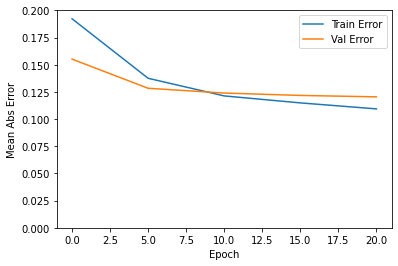

In [338]:
# График хода обучения
def plot_history(history):
  hist = pd.DataFrame(history/4)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0, 0.2])
  plt.legend()

plot_history(historysForGraph)

In [342]:
# Предсказание значений
preds_test = model.predict(validationData.drop(['AA'], axis = 1, inplace = False)).flatten()
# Просмотр прогноза
predsData = model.predict(validationData.drop(['AA'], axis = 1, inplace = False))
for i in range(20):
  print("Предсказанный рост:", round(predsData[i][0], 3), ", правильный рост:", round(validationData["AA"].values[i], 3))

Предсказанный рост: 0.205 , правильный рост: 0.138
Предсказанный рост: -0.037 , правильный рост: 0.376
Предсказанный рост: 0.162 , правильный рост: 0.217
Предсказанный рост: 0.033 , правильный рост: -0.412
Предсказанный рост: 0.688 , правильный рост: 0.444
Предсказанный рост: 0.377 , правильный рост: 0.433
Предсказанный рост: -0.081 , правильный рост: -0.09
Предсказанный рост: 0.291 , правильный рост: -0.151
Предсказанный рост: 0.087 , правильный рост: 0.238
Предсказанный рост: -0.129 , правильный рост: -0.324
Предсказанный рост: -0.035 , правильный рост: -0.016
Предсказанный рост: -0.03 , правильный рост: 0.043
Предсказанный рост: -0.007 , правильный рост: -0.048
Предсказанный рост: 0.002 , правильный рост: 0.206
Предсказанный рост: 0.0 , правильный рост: -0.029
Предсказанный рост: -0.128 , правильный рост: -0.461
Предсказанный рост: -0.044 , правильный рост: -0.009
Предсказанный рост: -0.077 , правильный рост: -0.104
Предсказанный рост: -0.1 , правильный рост: -0.073
Предсказанный ро